In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import math
import torch.nn.functional as F
import torch.nn as nn
import train
import torch.optim as optim
from plot import Plotter

## Part a

In [2]:
class DogDataset:
    """
    Dog Dataset.
    """
    def __init__(self, batch_size=4, dataset_path='data/images/dogs', if_resize=True):
        self.batch_size = batch_size
        self.dataset_path = dataset_path
        self.if_resize = if_resize
        self.train_dataset = self.get_train_numpy()
        self.x_mean, self.x_std = self.compute_train_statistics()
        self.transform = self.get_transforms()
        self.train_loader, self.val_loader = self.get_dataloaders()

    def get_train_numpy(self):
        train_dataset = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'train'))
        train_x = np.zeros((len(train_dataset), 224, 224, 3))
        # train_x = np.zeros((len(train_dataset), 64, 64, 3))
        for i, (img, _) in enumerate(train_dataset):
            train_x[i] = img
        return train_x / 255.0

    def compute_train_statistics(self):
        # TODO (part a): compute per-channel mean and std with respect to self.train_dataset
        
        x_mean = np.mean(self.train_dataset, axis=(0, 1, 2))  # per-channel mean
        x_std = np.std(self.train_dataset, axis=(0, 1, 2))  # per-channel std
        return x_mean, x_std

    def get_transforms(self):
        if self.if_resize:
            # TODO (part a): fill in the data transforms
            transform_list = [
                # resize the image to 32x32x3
                transforms.Resize((32, 32)),
                # convert image to PyTorch tensor
                transforms.ToTensor(),
                # normalize the image (use self.x_mean and self.x_std)
                transforms.Normalize(mean = self.x_mean, std = self.x_std)
            ]
        else: 
            # TODO (part f): fill in the data transforms
            # Note: Only change from part a) is there is no need to resize the image 
                transforms_list = [
                # convert image to PyTorch tensor
                transforms.ToTensor(),
                # normalize the image (use self.x_mean and self.x_std)
                transforms.Normalize(mean = self.x_mean, std = self.x_std)
            ]
        transform = transforms.Compose(transform_list)
        return transform

    def get_dataloaders(self):
        # train set
        train_set = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'train'), transform=self.transform)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=self.batch_size, shuffle=True)

        # validation set
        val_set = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'val'), transform=self.transform)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader

    def plot_image(self, image, label):
        image = np.transpose(image.numpy(), (1, 2, 0))
        image = image * self.x_std.reshape(1, 1, 3) + self.x_mean.reshape(1, 1, 3)  # un-normalize
        plt.title(label)
        plt.imshow((image*255).astype('uint8'))
        plt.show()

    def get_semantic_label(self, label):
        mapping = {'African_hunting_dog': 0, 'Chihuahua': 1, 'dhole': 3, 'dingo': 4, 'Japanese_spaniel': 2}
        # mapping = {'African_hunting_dog': 0, 'Chihuahua': 1, 'dhole': 2, 'dingo': 3, 'Japanese_spaniel': 4}
        reverse_mapping = {v: k for k, v in mapping.items()}
        return reverse_mapping[label]
    # def get_semantic_label(self, label):
    #     # Get the correct label mapping from ImageFolder's class_to_idx
    #     class_to_idx = self.train_loader.dataset.class_to_idx
    #     reverse_mapping = {v: k for k, v in class_to_idx.items()}  # reverse the mapping
    #     return reverse_mapping[label]

[0.50161345 0.45612671 0.3824407 ] [0.24617303 0.23615181 0.23905821]


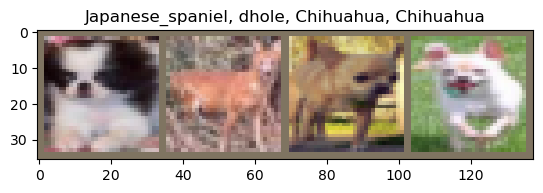

In [3]:
if __name__ == '__main__':
    dataset = DogDataset()
    print(dataset.x_mean, dataset.x_std)
    images, labels = next(iter(dataset.train_loader))
    dataset.plot_image(
        torchvision.utils.make_grid(images),
        ', '.join([dataset.get_semantic_label(label.item()) for label in labels])
    )

Thus, we can find that the x_mean is [0.5016, 0.4561, 0.3824], and the sd of x is [0.2462, 0.2361, 0.2391].

### Part a.1

If we resize the image, we could run our algorithm faster because we have less weights or parameters to learn. However, this may loss efficiency because lower the size of image would loss information, and thus decrease the accuracy of prediction. If we normalize the image, we could make the training more stable and could make the algorithm more likely to converge. However, incorrect normalization could introduce bias. 

### Part a.2

This is because if we compute the mean and sd on validation set, it is a kind of cheating because we are using what we already have to train the model, where in fact the validation set should be unobservable. This may violate the principle and integrity of training model because we are using data that we should never seen. 

## Part b

### Part b.1

If we connecting the input and the convolutional layer1, we have totally (1 + 5 * 5 * 3) * 16 = 1216 parameters. If we connecting convolutional layer2, we have totally (1 + 5 * 5 * 16) * 32 = 12832 parameters. If we connecting convolutional layer3, we have (1 + 5 * 5 * 32) * 64 = 51264 parameters. If we connecting layer4, we have (1 + 5 * 5 * 64) * 128 = 204928 parameters. If we connect layer5, we will have (128 * 2 * 2 + 1) * 64 = 32832 parameters. If we connect layer6, we have (64 + 1) * 5 = 325 parameters. Thus, we have totally 1216 + 12832 + 51264 + 204928 + 32832 + 325 = 303397 parameters. 

### Part b.2

If we set all initial weight to be 0, we will produce the same output during the foward pass and then receive the same gradient when start backward propagation algorithm. Also, if we initialize all weight to be zero, this may cause gradient vanishing problem. 

## Part c

In [4]:
class CNN(nn.Module):
    """
    Convolutional Neural Network.
    """
    def __init__(self):
        super().__init__()

        # TODO (part c): define layers
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)  # convolutional layer 1
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=2) # convolutional layer 2
        self.conv3 = nn.Conv2d(32, 64, 5, stride=2, padding=2) # convolutional layer 3
        self.conv4 = nn.Conv2d(64, 128, 5, stride=2, padding=2) # convolutional layer 4
        self.fc1 = nn.Linear(128 * 2 * 2, 64)   # fully connected layer 1
        self.fc2 =  nn.Linear(64, 5)  # fully connected layer 2 (output layer)

        self.init_weights()

    def init_weights(self):
        for conv in [self.conv1, self.conv2, self.conv3, self.conv4]:
            C_in = conv.weight.size(1)
            nn.init.normal_(conv.weight, 0.0, 1 / math.sqrt(5 * 2.5 * C_in))
            nn.init.constant_(conv.bias, 0.0)

        # TODO (part c): initialize parameters for fully connected layers
        for fc in [self.fc1, self.fc2]:
            if fc == self.fc1:
                f_in = fc.weight.size(1)
                nn.init.normal_(fc.weight, 0.0, 1/math.sqrt(256))
                nn.init.constant_(fc.bias, 0)
            if fc == self.fc2:
                f_in = fc.weight.size(1)
                nn.init.normal_(fc.weight, 0.0, 1/math.sqrt(32))
                nn.init.constant_(fc.bias, 0)


    def forward(self, x):
        N, C, H, W = x.shape

        # TODO (part c): forward pass of image through the network
        z = F.relu(self.conv1(x))
        z = F.relu(self.conv2(z))
        z = F.relu(self.conv3(z))
        z = F.relu(self.conv4(z))

        z = z.view(z.size(0), -1)

        z = F.relu(self.fc1(z))
        z = self.fc2(z)

        return z


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
if __name__ == '__main__':
    net = CNN()
    print(net)
    print('Number of CNN parameters: {}'.format(count_parameters(net)))
    dataset = DogDataset()
    images, labels = next(iter(dataset.train_loader))
    print('Size of model output:', net(images).size())

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)
Number of CNN parameters: 303397
Size of model output: torch.Size([4, 5])


## Part d

## Part e

### Part e.1

It seems that at first the training loss and the validation loss will both decrease. Then after certain number of epochs, the training loss will continue to decrease but the validation loss will then become higher and higher. If we continue, the training loss will then decrease to 0 but validation error may continue to increase.

### Part e.2

It seems that we should stop as epoch of 4 according the graph. If we trying to maximize the training accuracy, it may cause overfitting that our model performs very well on the training set, but poorly on the validation set.

## Part f